In [1]:
import bilby
import numpy as np
import matplotlib.pyplot as plt
from gwpy.timeseries import TimeSeries
from gwpy.signal.filter_design import bandpass, concatenate_zpks, notch
from gwpy.signal import filter_design
from gwpy.plot import Plot

/home/ethanmillar/gravwaves/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(True)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


# Setting Universal Parameters

In [2]:
sampling_frequency = 4096
duration = 4
minimum_frequency = 20

# Setting Simulated Signal Parameters

In [3]:
injection_parameters = dict(
    mass_1=36., 
    mass_2=29.,
    a_1=0.4, 
    a_2=0.3, 
    tilt_1=0.5, 
    tilt_2=1.0, 
    phi_12=1.7, 
    phi_jl=0.3,
    luminosity_distance=2000., 
    theta_jn=0.4, 
    psi=2.659,
    phase=1.3, 
    geocent_time=1126259642.413, 
    ra=1.375, 
    dec=-1.2108
    )

waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2", #Where in the source code are the lists of approximants specified?
    #reference_frequency=minimum_frequency,
    minimum_frequency=minimum_frequency,
    start_time=injection_parameters["geocent_time"] - 2
)

waveform_generator = bilby.gw.WaveformGenerator(
    duration = duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, #Where in the source code references the available time domain source models 
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)


18:18 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


# Defining the Strain Data

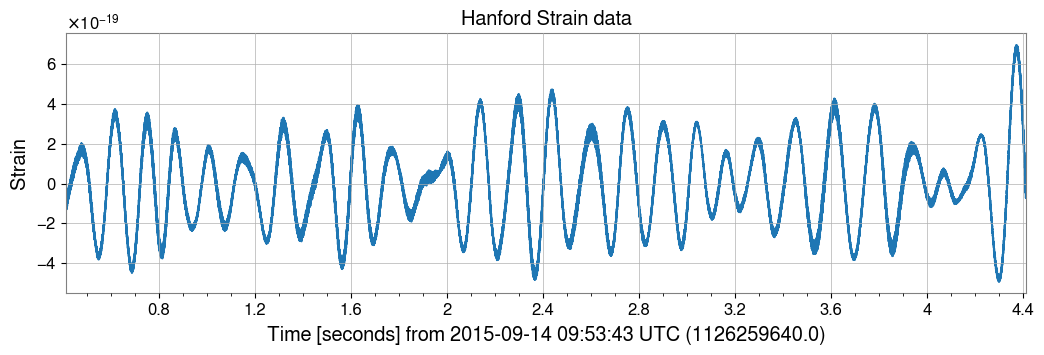

In [4]:
start_time = injection_parameters["geocent_time"] - 2
end_time = start_time + duration
time_series = TimeSeries.fetch_open_data('H1', start_time, end_time)

plot = time_series.plot()

ax = plot.gca()
ax.set_title('Hanford Strain data')
ax.set_ylabel('Strain')

plot = plt.show()

## Plotting the generated wave with no noise

Plotting the simualted waveform for troubleshooting, allows us to see what the waveform looks like in isolation

18:21 bilby WARNING : Injecting signal outside segment, start_time=0, merger time=1126259642.413.
18:21 bilby INFO    : Injected signal in H1:
18:21 bilby INFO    :   optimal SNR = 11.78
18:21 bilby INFO    :   matched filter SNR = 11.78+0.00j
18:21 bilby INFO    :   mass_1 = 36.0
18:21 bilby INFO    :   mass_2 = 29.0
18:21 bilby INFO    :   a_1 = 0.4
18:21 bilby INFO    :   a_2 = 0.3
18:21 bilby INFO    :   tilt_1 = 0.5
18:21 bilby INFO    :   tilt_2 = 1.0
18:21 bilby INFO    :   phi_12 = 1.7
18:21 bilby INFO    :   phi_jl = 0.3
18:21 bilby INFO    :   luminosity_distance = 2000.0
18:21 bilby INFO    :   theta_jn = 0.4
18:21 bilby INFO    :   psi = 2.659
18:21 bilby INFO    :   phase = 1.3
18:21 bilby INFO    :   geocent_time = 1126259642.413
18:21 bilby INFO    :   ra = 1.375
18:21 bilby INFO    :   dec = -1.2108


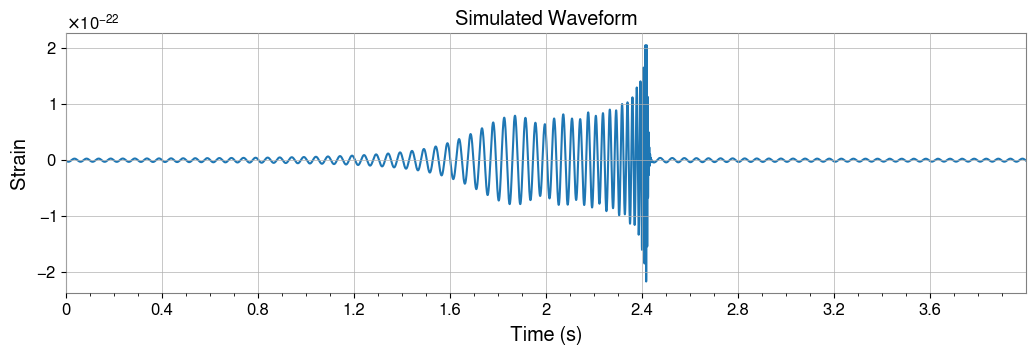

In [5]:
#Setting empty interferometer 
H1 = bilby.gw.detector.get_empty_interferometer('H1')

#Setting the strain data with zero noise
H1.set_strain_data_from_zero_noise(sampling_frequency=sampling_frequency, duration=duration)

#Injecting generated waveform into interferomoter
H1.inject_signal_from_waveform_generator(parameters=injection_parameters, waveform_generator=waveform_generator)

#Converting strain data into timeseries
timeseries_no_noise = TimeSeries(
            data=H1.strain_data.time_domain_strain, times=H1.strain_data.time_array)

#Plotting the simulated waveform

plot = timeseries_no_noise.plot()

ax = plot.gca()
ax.set_title('Simulated Waveform')
ax.set_ylabel('Strain')
plt.xlabel('Time (s)')

plot = plt.show()

# Injecting the signal into the GWOSC Strain

18:21 bilby INFO    : Injected signal in H1:
18:21 bilby INFO    :   optimal SNR = 11.78
18:21 bilby INFO    :   matched filter SNR = -19.19+8.64j
18:21 bilby INFO    :   mass_1 = 36.0
18:21 bilby INFO    :   mass_2 = 29.0
18:21 bilby INFO    :   a_1 = 0.4
18:21 bilby INFO    :   a_2 = 0.3
18:21 bilby INFO    :   tilt_1 = 0.5
18:21 bilby INFO    :   tilt_2 = 1.0
18:21 bilby INFO    :   phi_12 = 1.7
18:21 bilby INFO    :   phi_jl = 0.3
18:21 bilby INFO    :   luminosity_distance = 2000.0
18:21 bilby INFO    :   theta_jn = 0.4
18:21 bilby INFO    :   psi = 2.659
18:21 bilby INFO    :   phase = 1.3
18:21 bilby INFO    :   geocent_time = 1126259642.413
18:21 bilby INFO    :   ra = 1.375
18:21 bilby INFO    :   dec = -1.2108


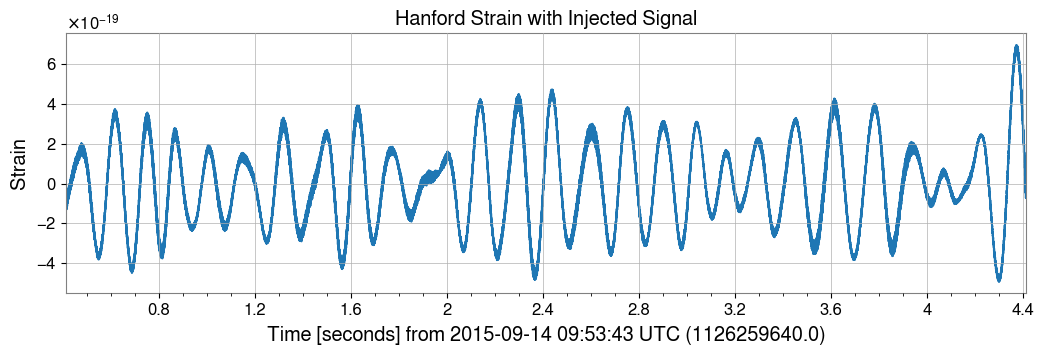

In [6]:
data_injected, metadata = bilby.gw.detector.inject_signal_into_gwpy_timeseries(data = time_series,
    waveform_generator=waveform_generator, parameters=injection_parameters, det = 'H1'
)

plot = data_injected.plot()

ax = plot.gca()
ax.set_ylabel('Strain')
ax.set_title('Hanford Strain with Injected Signal')

plt.show()

# Filtering the data

/home/ethanmillar/gravwaves/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


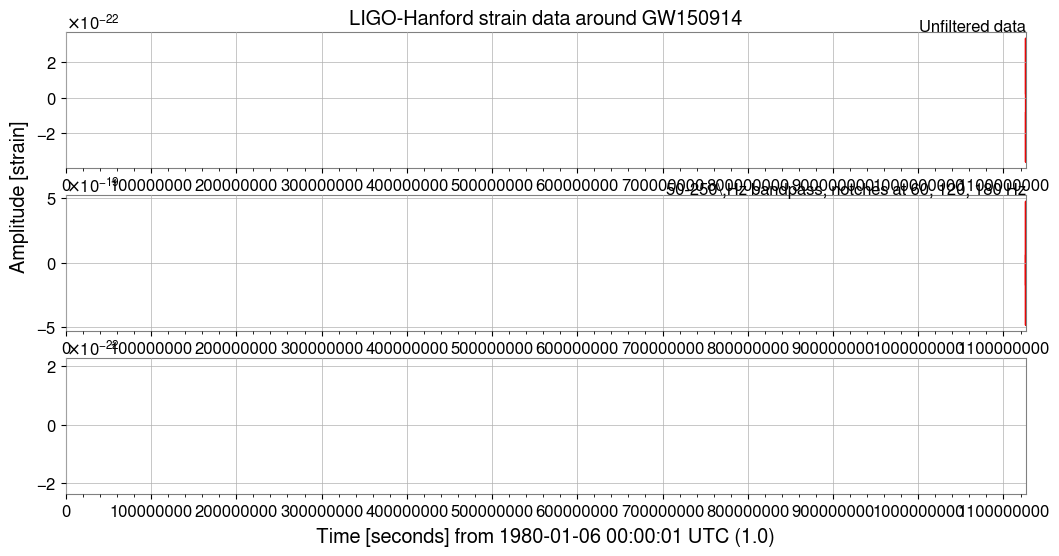

In [7]:
#Setting the bandpass filter to cut out high and low frequencies
bp = filter_design.bandpass(50, 250, time_series.sample_rate)

#Setting notch filters for the first 3 harmonics of 60Hz AC mains power supply
notches = [filter_design.notch(line, time_series.sample_rate) for
           line in (60, 120, 180)]

#Concatenate filters together
zpk = filter_design.concatenate_zpks(bp, *notches)

#Applying the filter
data_filtered = data_injected.filter(zpk, filtfilt=True)

#Cropping the data to remove corrupted data at the beginning and end of data (caused by filter) 
data_filtered = data_filtered.crop(*data_filtered.span.contract(1))

#Cropping unfiltered data for comparison
data_injected_crop = data_injected.crop(*data_injected.span.contract(1))
timeseries_no_noise_crop = timeseries_no_noise.crop(*timeseries_no_noise.span.contract(1))

plot = Plot(data_filtered, data_injected_crop, timeseries_no_noise_crop, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2, ax3 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

# Plotting Q-scan of the signal Data

/home/ethanmillar/gravwaves/lib/python3.10/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


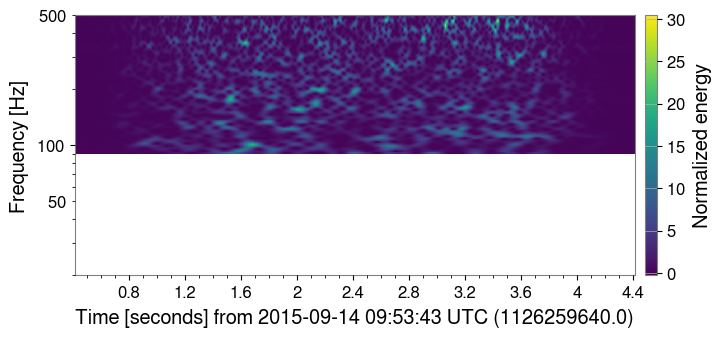

In [8]:
#Performing Q-transform of the injected data timeseries
qspecgram = data_injected.q_transform()

plot = qspecgram.plot(figsize=[8, 4])
ax = plot.gca()

ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(False)
ax.colorbar(cmap='viridis', label='Normalized energy')

plt.savefig('Q_scan.jpeg')
plot.show()

## Plotting Q-Scan from Gravity Spy Code

# Gravity Spy Plot

In [9]:
# -*- coding: utf-8 -*-
# Copyright (C) Scott Coughlin (2017-)
#
# This file is part of gravityspy.
#
# gravityspy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# gravityspy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with gravityspy.  If not, see <http://www.gnu.org/licenses/>.

"""Plotting tool for gravityspy
"""

from matplotlib import use
use('agg')
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

from mpl_toolkits.axes_grid1 import make_axes_locatable

from gwpy.plot import Plot

import numpy


def plot_qtransform(specsgrams, plot_normalized_energy_range, plot_time_ranges,
                    detector_name, start_time, **kwargs):
    """Fetch raw data around a glitch

    Parameters:

        specsgrams (list):
            A list of `gwpy.spectrogram.Spectrogram` objects

        plot_normalized_energy_range (array):
            The min and max of the colorbar for the plots

        plot_time_ranges (array):
            The duration assosciated with each plot to be made

        detector_name (str):
            What detetor where these spectrograms from

        start_time (float):
            What was the start time of the data used for these spectrograms
            this effects what the plot title is (ER10 O1 O2 etc)

    Returns:

        ind_fig_all
            A list of individual spectrogram plots
        super_fig
            A single `plot` object contianing all spectrograms
    """
    frange = kwargs.pop('frange', [10, 2048])

    # Set some plotting params
    myfontsize = 15
    mylabelfontsize = 20
    my_color = 'k'
    if detector_name == 'H1':
        title = "Hanford"
    elif detector_name == 'L1':
        title = "Livingston"
    elif detector_name == 'V1':
        title = "VIRGO"
    elif detector_name == 'G1':
        title = "GEO"
    elif detector_name == 'K1':
        title = "KAGRA"
    else:
        raise ValueError('You have supplied a detector '
                         'that is unknown at this time.')

    if start_time < 1126400000:
        title = title + ' - pre O1'
    elif 1126400000 < start_time < 1137250000:
        title = title + ' - O1'
    elif 1137250000 < start_time < 1161907217:
        title = title + ' - post O1 pre ER10'
    elif 1161907217 < start_time < 1164499217:
        title = title + ' - ER10'
    elif 1164499217 < start_time < 1219276818:
        title = title + ' - O2a'
    elif 1219276818 < start_time < 1228838418:
        title = title + ' - post O2 pre ER13'
    elif 1228838418 < start_time < 1229176818:
        title = title + ' - ER13'
    elif 1229176818 < start_time < 1235750418:
        title = title + ' - post ER13 pre O3'
    elif 1235750418 <start_time < 1238112018:
        title = title + ' - ER14'
    elif 1238112018 <start_time:
        title = title + ' - O3'
    else:
        raise ValueError('Time outside science or engineering run '
                         'or more likely code not updated to reflect '
                         'new science run.')

    ind_fig_all = []

    for i, spec in enumerate(specsgrams):

        ind_fig = spec.plot(figsize=[8, 6])

        ax = ind_fig.gca()
        ax.set_position([0.125, 0.1, 0.775, 0.8])
        ax.set_yscale('log', base=2)
        ax.set_xscale('linear')
        ax.grid(False)

        dur = float(plot_time_ranges[i])

        xticks = numpy.linspace(spec.xindex.min().value,
                                spec.xindex.max().value, 5)

        xticklabels = []
        for itick in numpy.linspace(-dur/2, dur/2, 5):
            xticklabels.append(str(itick))

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        ax.set_xlabel('Time (s)', labelpad=0.1, fontsize=mylabelfontsize,
                      color=my_color)
        ax.set_ylabel('Frequency (Hz)', fontsize=mylabelfontsize,
                      color=my_color)
        ax.set_title(title, fontsize=mylabelfontsize, color=my_color)
        ax.title.set_position([.5, 1.05])
        ax.set_ylim(frange)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(axis='y', style='plain')

        plt.tick_params(axis='x', which='major', labelsize=myfontsize)
        plt.tick_params(axis='y', which='major', labelsize=12)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="3%")

        cbar = ind_fig.colorbar(cax=cax, cmap='viridis',
                                label='Normalized energy',
                                clim=plot_normalized_energy_range)

        cbar.ax.tick_params(labelsize=12)
        cbar.ax.yaxis.label.set_size(myfontsize)

        ind_fig_all.append(ind_fig)

    # Create one image containing all spectogram grams
    super_fig, axes = plt.subplots(nrows=1, ncols=len(specsgrams),
                                      sharey=True,
                                      subplot_kw={'xscale': 'auto-gps'},
                                      figsize=(27, 6), FigureClass=Plot)
    count = 0

    for iax, spec in zip(axes, specsgrams):
        iax.imshow(spec)

        iax.set_yscale('log', base=2)
        iax.set_xscale('linear')

        xticks = numpy.linspace(spec.xindex.min().value,
                                spec.xindex.max().value, 5)
        dur = float(plot_time_ranges[count])

        xticklabels = []
        for itick in numpy.linspace(-dur/2, dur/2, 5):
            xticklabels.append(str(itick))

        iax.set_xticks(xticks)
        iax.set_xticklabels(xticklabels)

        iax.set_xlabel('Time (s)', labelpad=0.1, fontsize=mylabelfontsize,
                       color=my_color)
        iax.set_ylim(frange)
        iax.yaxis.set_major_formatter(ScalarFormatter())
        iax.ticklabel_format(axis='y', style='plain')
        iax.colorbar(clim=plot_normalized_energy_range)
        count = count + 1

    super_fig.suptitle(title, fontsize=mylabelfontsize, color=my_color, x=0.51)

    return ind_fig_all, super_fig

In [10]:
myfontsize = 15
mylabelfontsize = 20
my_color = 'k'
detector_name = 'H1'